# iLykei Lecture Series

# Advanced Machine Learning and Artificial Intelligence (MScA 32017)

# Reinforcement Learning

## Notebook 3: Revenue Management using Reinforcement Learning

## Yuri Balasanov, Mihail Tselishchev, &copy; iLykei 2019

##### Main texts: 

**Hands-On Machine Learning with Scikit-Learn and TensorFlow, Aurelien Geron, &copy; Aurelien Geron 2017, O'Reilly Media, Inc**

**Reinforcement Learning: An Introduction (Adaptive Computation and Machine Learning series), &copy; 2018 Richard S. Sutton, Andrew G. Barto, The MIT Press**

In this notebook we train an agent to sell tickets for one-leg flights from New York to London using Q-Learning algorithm. We also compare achived results with a well-known Revenue Management heuristic algorithm [EMSRb](https://en.wikipedia.org/wiki/Expected_marginal_seat_revenue).

In [1]:
%matplotlib notebook

### Running instructions

Make sure that project files `remote_revenue_env.py` and `revenue.proto` are in the same directory as this notebook.

To run this project it is necessary to have internet connection and permission to communicate with iLykei real time platform.

Have the following packages installed in your environment: `numpy`, `matplotlib` and `protobuf` or run the following command:

> `conda install numpy matplotlib protobuf`

If packages are installed correctly, the following command compiles `revenue.proto`, containing the structure of communication messages with the server side, into `revenue_pb2.py`:

In [2]:
!protoc --python_out=./ revenue.proto

### Yield management problem as reinforcement learning

#### Introduction

This project is a modified version of the method described in article:

**Real-time dynamic pricing in a non-stationary environment using model-free reinforcement learning, Rupal Rana,Fernando S. Oliveira, Omega, Volume 47, September 2014, Pages 116-126, Elsevier**

See also further references there.

Dynamic pricing (yield management, revenue management) is a strategy of adjusting in real time price of a product in order to allocate the right service to the right customer at the right time while maximizing revenue. It is usually applied when demand for the product is stochastic. The key requirement that the seller has to face is that entire capacity has to be sold by fixed deadline 

Typical assumptions of yield management are: full capacity is available at the beginning of the period, no reordering is allowed and the unsold products after the deadline have zero salvage value. However, these assumptions can be relaxed to a certain degree.

Examples of applications of dynamic pricing strategies cover a broad range of manufactured goods and services, such as, to name a few, food, electronic goods and garments, airline tickets, hotel reservations, tickets for theaters, concerts or sports arenas. 

This project considers single product (economy cabin of one-leg flight). Most typical assumptions of strategies for such single product applications are: customer demand is random and depends on price of the product with some unknown elasticity, i.e. demand is inversely proportional to price. Traditionally strategies require a model predicting the distribution of demand for each price level. Demand model needs to be estimated from observations of actual demand, it has very significant influence on performance of the strategy.

Application of reinforcement learning creates advantage of model-free strategy, i.e. demand is not characterized by a particular distribution.

#### Dynamic pricing problem as Markov decision process

Dynamic pricing problem fits well within problems based on discrete finate Markov decision processes because pricing is a real time decision process in a stochastic environment with finite number of states (remaining capacity and remaining units of time before the deadline) and decisions depend only on the current, but not previous states.

In order to avoid complexity of continuous price updates assume that price can only be reviewed and changed periodically at equal time steps.

Describe more formally the MDP for yield management problem:
- Let $n$ be the total capacity (i.e. total number of units to sell) and $m$ be the total number of times when the price can change 
- Variable $x_t$ represents remaining capacity at time $t$ and can take values $\{1,2,\ldots,n\},~t=\{0,1,\ldots,m\}$
- Remaining time to the deadline is $\tau_t=m-t$
- $A(x_t)$ is the set of allowed prices when remaining capacity at time $t$ is $x_t$. Prices $a_t \in A(x_t)$ are the actions available to agent
- State of the Markov process describing the environment is then $S_t=<x_t,\tau_t>$
- Transition probabilities $p(S_{t+1}|S_t,a_t)$ that at time $t+1$ Markov process state is $S_{t+1}=<x_{t+1},\tau_{t+1}>$, given that at time $t$ it was $S_t=<x_t,\tau_t>$ and the action (price) selected at time $t$ was $a_t$
- Expected immediate revenue (reward) gained as a result of selecting price $a_t$ when remaining capacity was $x_t$ at time $t$ is $r(S_t,a_t)$
- Policy of agent (pricing strategy) is formalized as discrete distribution on the set of available actions or probabilities $\pi(a|s)$ of selecting action $a$ in state $s$ 

The objective is maximization of total expected revenue. Optimization is achieved by solving the action-value Bellman optimality equation using method of dynamic programing through iterations:
$$Q_{k+1}(s,a)=\sum_{s',r}p(s',r|s,a) \left[r+\gamma \max_{a'}Q_k(s',a') \right],$$
where $\gamma$ is the discount factor for rewards and $k$ is index of iterations of adjustments of the action-value function.

#### Dynamic pricing problem as Q-learning

Note that knowing transition probabilities $p(S_{t+1}|S_t,a_t)$ is in fact equivalent to knowing distribution of the demand. Under the assumption of known demand distribution there have been known solutions developed within operations research, for example, solution based on the Littlewood's Two-Class model. This model will be considered for comparison in the last section.

Knowledge of transition probabilities allows solving for optimal strategy using dynamic programming applied to MDP. However, assumption of availability of transition probabilities is not realistic. 

Reinforcement learning problem can still be solved in case when MDP is not fully defined: transition probabilities and rewards are not initially known. In such case solution cannot be found by dynamic programming. The method that has to be used instead of dynamic programming is Q-learning. Agent will acquire knowledge about environment transitions indirectly (not explicitly in the form of transition probabilities matrix) and gradually in the process of interaction. Besides the advantage of being model-free the Q-learning approach is adaptive: agent continues learning and adapting to the changing environment. 

Q-learning is based on the temporal difference version of action-value Bellman optimality equation
$$
Q_{t+1} (s_t,a_t) = (1-\alpha) Q_t (s_t,a_t) + \alpha  \left(r_{t+1} + \gamma \cdot \max_{a_{t+1}} Q_t(s_{t+1},a_{t+1})\right),
$$
$$
=  Q_t (s_t,a_t) + \alpha \left[\left(r_{t+1} + \gamma \cdot \max_{a_{t+1}} Q_t(s_{t+1},a_{t+1})\right) - Q_k (s_t,a_t) \right],
$$
where $\alpha$ is learning rate and $s_{t+1},r_{t+1}$ are next step $t+1$ observations of state and immediate reward after at state $s_t$ action $a_t$ was selected.

Term 
$$\delta_t = \left[\left(r_{t+1} + \gamma \cdot \max_{a_{t+1}} Q_t(s_{t+1},a_{t+1})\right) - Q_t (s_t,a_t) \right]$$ 
is TD error, it is the difference between the target $\left(r_{t+1} + \gamma \cdot \max_{a_{t+1}} Q_t(s_{t+1},a_{t+1})\right)$ and the current value of the action-value function $Q_t (s_t,a_t)$. Then $\alpha \delta_t$ is the adjustment to the state-value function $Q_t (s_t,a_t)$ at the next time $t+1$ with learning rate $\alpha$   

### Description of Air Ticket Sale Environment

The agent needs to sell `100` tickets for a one-leg flight before the deadline. We call one session of selling tickets before the deadline **episode**.
The agent is allowed to update ticket price `10` times per each episode. We call every time interval with fixed ticket fare **sub-episode**.

All classes required for interaction with the environment are located in `remote_revenue_env.py`. 

Create an environment:

In [3]:
from remote_revenue_env import RemoteRevenueEnv

env = RemoteRevenueEnv(episode_duration=100, plotting=True, redraw_seconds=0.05)

Under the hood, object `env` connects to remote server, waits for the next selected price by the agent and records customers coming in and buying tickets for the selected price.

Total capacity of the flight (`100`), number of sub-episodes per episode (`10`) and possible ticket fares can be obtained like follows:

In [4]:
print('Total capacity:', env.total_capacity)
print('Subepisodes:', env.time_horizon)
print('Ticket Fares:', env.action_space)

Total capacity: 100
Subepisodes: 10
Ticket Fares: [300, 400, 500, 600, 700, 800, 900, 1000]


Before each sub-episode, the agent selects price from `env.action_space` at which tickets are going to be offered. Let the agent choose the highest possible price (that is `1000`). The following cell shows the result of the first episode with selected price `1000`. Note that the episode gets reset by `env.reset()`.

<IPython.core.display.Javascript object>


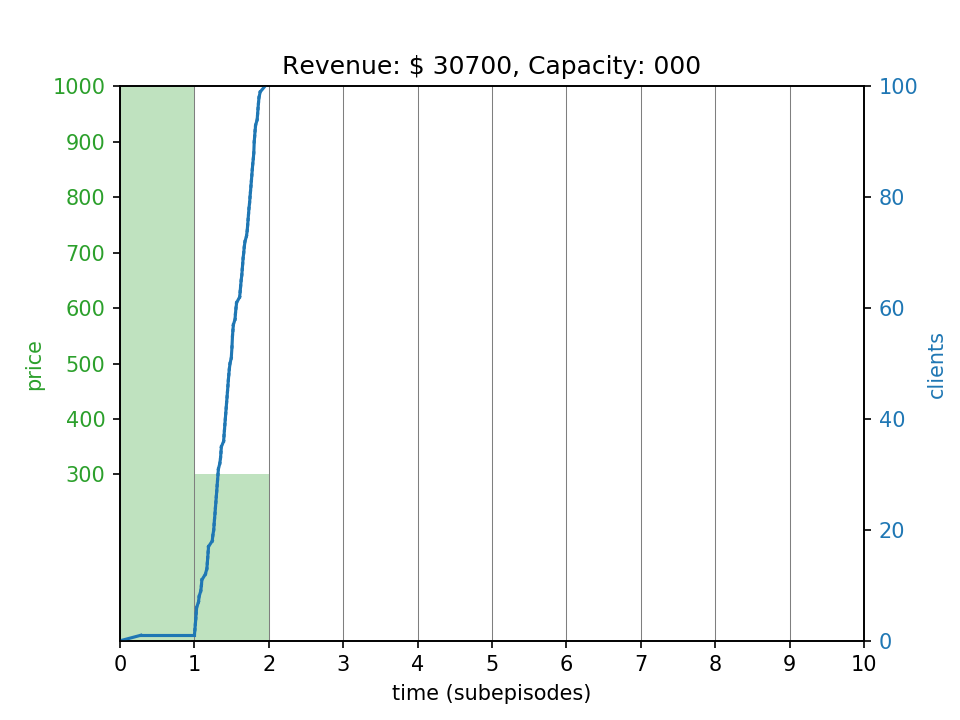

In [5]:
obs = env.reset()
action = 1000
obs, reward, done, info = env.step(action)

The agent sets the price for the next sub-episode via method `env.step(action)`. This method returns some useful statistics:
- observation `obs` is a pair `(capacity_left, subepisodes_left)`; 
- `reward` contains revenue for sub-episode;
- `done` is `True` if all tickets are sold or no sub-episodes left, otherwise - `False`;
- `info` contains additional information.

In [6]:
print('obs =', obs)
print('reward =', reward)
print('done =', done)
print('info =', info)

obs = (99, 9)
reward = 1000
done = False
info = {'revenue': 1000, 'last_action': 1000, 'new_clients': 1}


Obviously, not a lot of people are willing to pay `$1000` for the flight! 

Check what happens if the agent sets the lowest possible price. Results of the following cell will be added to the previous graph starting from second sub-episode. 

In [7]:
while not done:
    obs, reward, done, info = env.step(300)
print(f'Revenue: {info["revenue"]}, capacity left: {obs[0]}')

Revenue: 30700, capacity left: 0


What if the agent choses prices randomly? Try to implement this logic.

## Solving the Problem with Q-Learning Algorithm

In order to approximate Q-values of the environment we use Q-Learning iterative algorithm, which applies some _exploration policy_ while interacting with the graph of the game and updates estimates of Q-Values for current state $s_t$ and chosen action $a_t$ at each step:
$$
    Q_{t+1} (s_t,a_t) = (1-\alpha) Q_t (s_t,a_t) + \alpha \left(r_{t+1} + \gamma \cdot \max_{a_{t+1}} Q_t(s_{t+1},a_{t+1})\right),
$$
where $s_{t+1}$ is the state resulting from selecting action $a_t$ at state $s_t$ and $r_{t+1}$ is the immediate reward collected in transition from $s_t$ to $s_{t+1}$. 
In our environment, state is a pair of `(capacity_left, subepisodes_left)`.

Following class is designed to calculate iteration steps and to choose action with the highest Q-value at the given state.

In [8]:
class QLearn:
    def __init__(self, gamma=0.95, alpha=0.05):
        from collections import defaultdict
        self.gamma = gamma
        self.alpha = alpha
        self.qmap = defaultdict(int)

    def iteration(self, old_state, old_action, reward, new_state, new_possible_actions):
        # Produce iteration step (update Q-Value estimates)
        old_stateaction = tuple(old_state) + (old_action,)
        max_q = max([self.qmap[tuple(new_state) + (a,)] for a in new_possible_actions])
        self.qmap[old_stateaction] = (1-self.alpha)*self.qmap[old_stateaction] + self.alpha*(reward+self.gamma*max_q)
        return

    def best_action(self, state, possible_actions):
        # Get the action with highest Q-Value estimate for specific state
        a, q = max([(a, self.qmap[tuple(state) + (a,)]) for a in possible_actions], key=lambda x: x[1])
        return a

To explore the environment use $\varepsilon$-greedy strategy:

In [9]:
import random

def egreedy_strategy(ql, state, possible_actions, eps=0.0):
    # eps-greedy strategy
    # ql is a QLearn object
    if random.random() < eps:
        # select random action
        action = random.choice(possible_actions)
    else:
        # select action with max Q-Value estimate
        action = ql.best_action(state, possible_actions)
    return action

Following function explores the graph of the process and arranges Q-learning iterations:

In [10]:
def play_and_train(env, eps, n_games, ql, training):
    scores = []
    for _ in range(n_games):
        obs = env.reset()
        done = False
        score = 0
        while not done:
            # select next action using eps-greedy strategy
            action = egreedy_strategy(ql, obs, env.action_space, eps=eps)
            new_obs, reward, done, info = env.step(action)
            score += reward
            if training:
                # update Q-Value estimates
                ql.iteration(obs, action, reward,
                             new_obs, env.action_space)
            obs = new_obs
        scores.append(score)
    return scores

Now start the process of Q-Learning. Since the agent needs to play thousands of episodes to make reasonable estimation of Q-Values, use class `RemoteRevenueTrainEnv` instead of `RemoteRevenueEnv`. This class allows to simulate episodes much faster because client-server communication in it is reduced to just once per sub-episode. Communicated information is the number of tickets purchased during the sub-episode. The logic of the environment remains the same.

In [11]:
from remote_revenue_env import RemoteRevenueTrainEnv

env = RemoteRevenueTrainEnv()

ql = QLearn(gamma=0.95, alpha=0.05)
train_scores = []  # container for train results
n_games = 100000  # number of episodes per eps for training
eps_list = [0.9, 0.7, 0.5, 0.3, 0.2, 0.1, 0.05, 0.0]
for eps in eps_list:
    print('Training with eps = {} ...'.format(eps))
    train_scores += play_and_train(env, eps, n_games, ql, training=True)
print('Done.')

Training with eps = 0.9 ...
Training with eps = 0.7 ...
Training with eps = 0.5 ...
Training with eps = 0.3 ...
Training with eps = 0.2 ...
Training with eps = 0.1 ...
Training with eps = 0.05 ...
Training with eps = 0.0 ...
Done.


Show how revenue improves during training. Use moving average to smooth results.

<IPython.core.display.Javascript object>


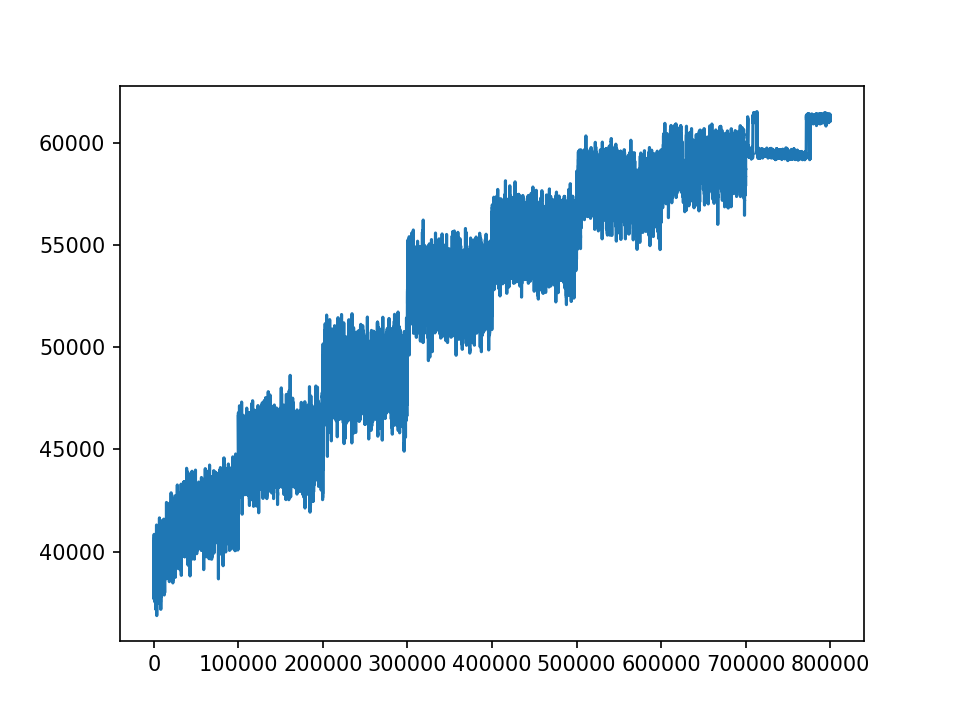

In [12]:
import matplotlib.pyplot as plt

def moving_average(v, window=100):
    out = []
    for j in range(len(v)):
        out.append(sum(v[max(j-window+1, 0):j]) / (min(j, window) + 1))
    return out

ma_train_scores = moving_average(train_scores)
plt.figure()
plt.plot(ma_train_scores[100:])

Now simulate 1000 episodes without training to evaluate how good results are:

In [13]:
test_scores = play_and_train(env, 0, 1000, ql, training=False)

Calculate quartile statistics:

In [14]:
import numpy as np

quartiles = [np.percentile(test_scores, p) for p in [0, 25, 50, 75, 100] ]
print(quartiles)

[58000.0, 61900.0, 62500.0, 63000.0, 64500.0]


Visualize results using `RemoteRevenueEnv` class.

<IPython.core.display.Javascript object>


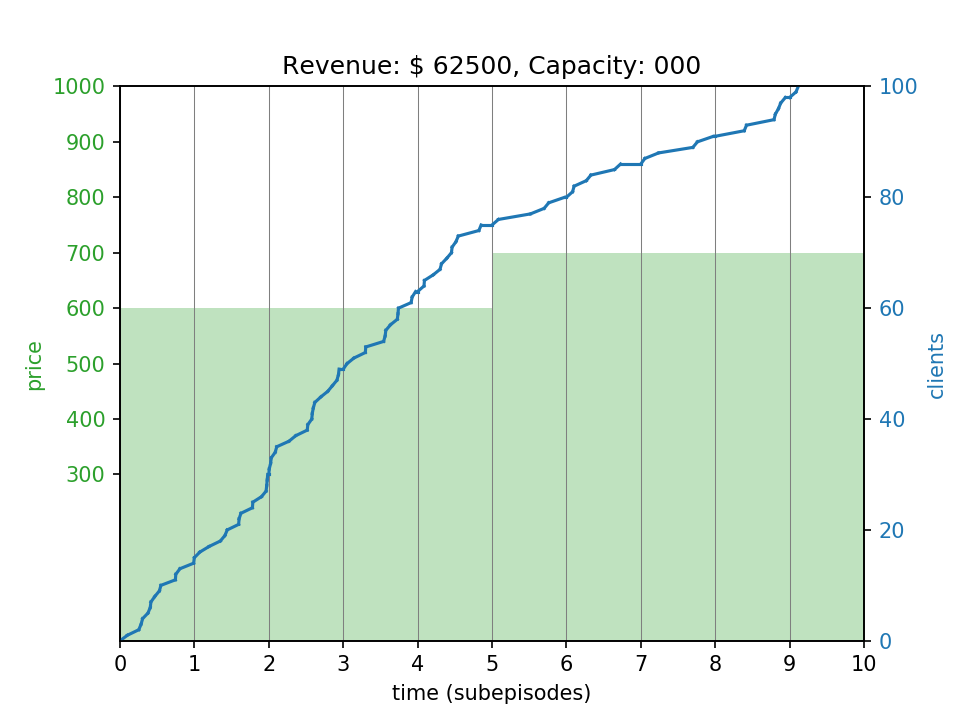

Episode # 1, revenue: 62500, capacity left: 0


<IPython.core.display.Javascript object>


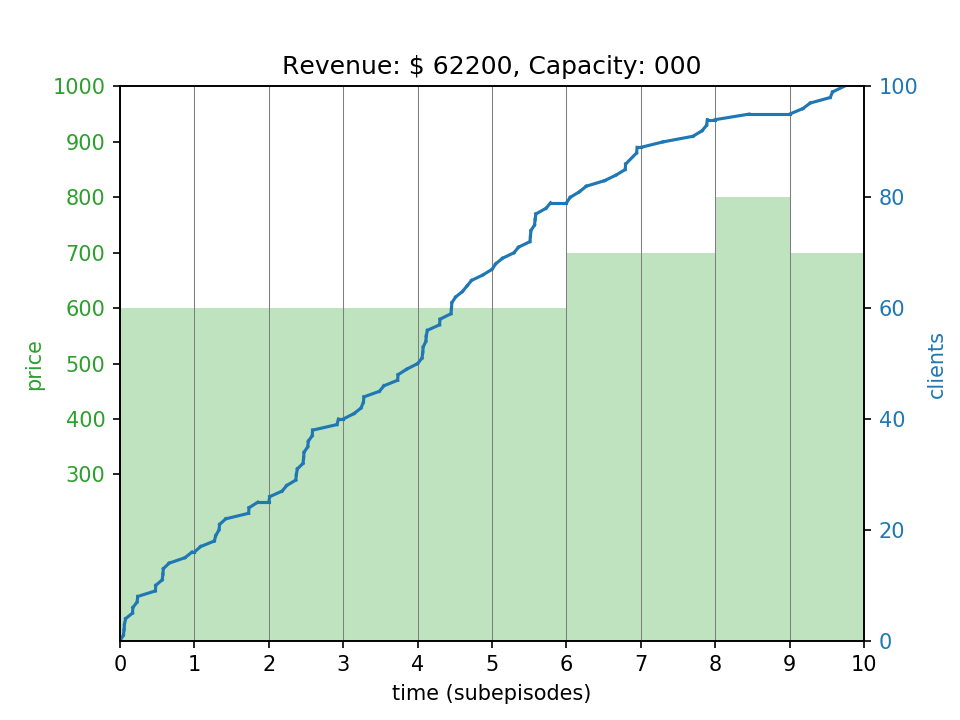

Episode # 2, revenue: 62200, capacity left: 0


In [15]:
env = RemoteRevenueEnv()
n_games = 2
for i in range(n_games):
    obs = env.reset()
    done = False
    while not done:
        action = egreedy_strategy(ql, obs, env.action_space, eps=0)
        obs, reward, done, info = env.step(action)
    print(f'Episode # {i+1}, revenue: {info["revenue"]}, capacity left: {obs[0]}')

## EMSRb algorithm

In this section we apply [EMSRb](https://en.wikipedia.org/wiki/Expected_marginal_seat_revenue) algorithm to the same problem. You may remember it from iLykei Lecture Series course on Real Time Analysis.

Install package `revpy` by running the following command:
> `pip install revpy`

First, collect data and estimate expectation and standard deviation of customer demand for every possible price.

In [16]:
# collect statistics for ESMR-b
import numpy as np
from remote_revenue_env import RemoteRevenueTrainEnv

env = RemoteRevenueTrainEnv(prune_overbook=False)

fares = sorted(env.action_space, reverse=True)
ngames = 1000  # per price
d_means = []
d_sigmas = []

for price in fares:
    demands = []
    for _ in range(ngames):        
        obs = env.reset()
        done = False
        d = 0  # demand in current episode
        while not done:
            obs, reward, done, info = env.step(price)
            d += info['new_clients']
        demands.append(d)
    d_means.append(np.mean(demands))
    d_sigmas.append(np.std(demands))

fares = np.array(fares)
d_means = np.array(d_means)
d_sigmas = np.array(d_sigmas)

print('Fares:', fares)
print('Means:', d_means)
print('Sigmas:', d_sigmas)

Fares: [1000  900  800  700  600  500  400  300]
Means: [   9.96    19.184   36.942   72.235  135.877  262.608  500.519  967.259]
Sigmas: [   3.06372323    4.45624775    6.22564342    8.71089978   16.00718186
   31.86493898   83.5545788   170.32719078]


Once the data are collected, implement the strategy, coded below.

In [17]:
def emsrb_strategy(capacity_left, fares, protection_levels):
    for j in reversed(range(len(fares))):
        if capacity_left >= protection_levels[j]:
            return fares[j]

Simulate 1000 episodes to evaluate the EMSRb strategy:

In [18]:
from revpy.revpy import protection_levels

env = RemoteRevenueTrainEnv()

ngames = 1000
emsrb_scores = []

for _ in range(ngames):        
    obs = env.reset()
    done = False
    subepisodes_left = env.time_horizon
    while not done:
        fractiontime_left = subepisodes_left / env.time_horizon
        pl = protection_levels(fares, d_means*fractiontime_left, 
                               d_sigmas*np.sqrt(fractiontime_left), method='EMSRb')
        action = emsrb_strategy(obs[0], fares, pl)
        obs, reward, done, info = env.step(action)
        subepisodes_left -= 1
    emsrb_scores.append(info['revenue'])

Calculate quartile statistics:

In [19]:
emsrb_quartiles = [np.percentile(emsrb_scores, p) for p in [0, 25, 50, 75, 100] ]
print(emsrb_quartiles)

[53600.0, 60900.0, 63000.0, 64500.0, 70000.0]


Visualize results using `RemoteRevenueEnv` class.

<IPython.core.display.Javascript object>


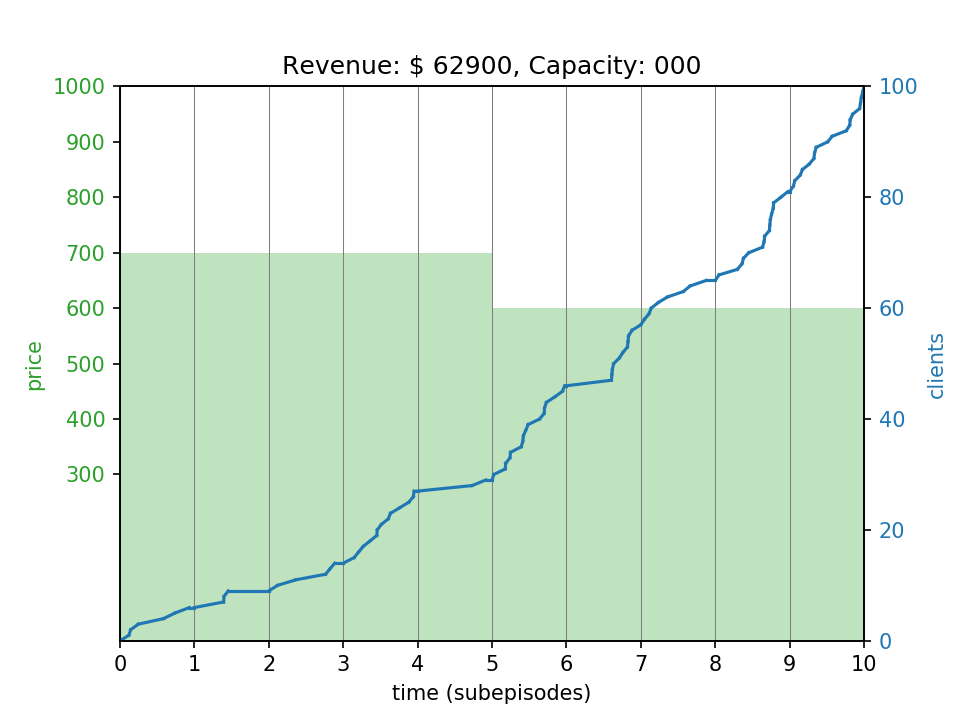

Episode # 1, revenue: 62900, capacity left: 0


<IPython.core.display.Javascript object>


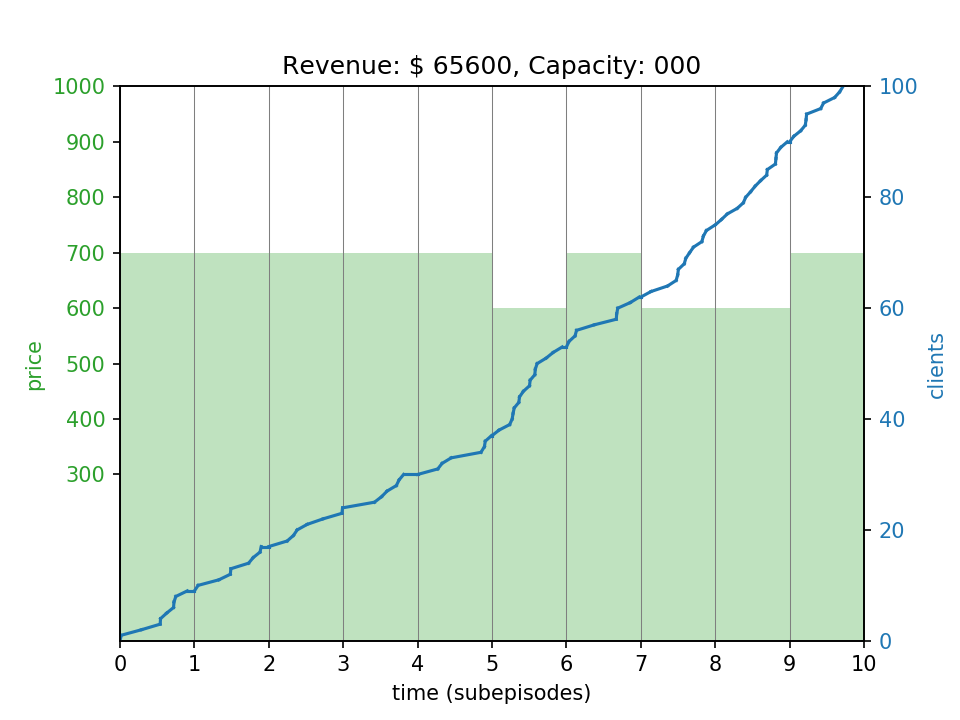

Episode # 2, revenue: 65600, capacity left: 0


In [20]:
from remote_revenue_env import RemoteRevenueEnv

env = RemoteRevenueEnv(episode_duration=100, plotting=True, redraw_seconds=0.05)
n_games = 2

for i in range(n_games):
    obs = env.reset()
    done = False
    subepisodes_left = env.time_horizon
    while not done:
        fractiontime_left = subepisodes_left / env.time_horizon
        pl = protection_levels(fares, d_means*fractiontime_left, 
                               d_sigmas*np.sqrt(fractiontime_left), method='EMSRb')
        action = emsrb_strategy(obs[0], fares, pl)
        obs, reward, done, info = env.step(action)
        subepisodes_left -= 1
    print(f'Episode # {i+1}, revenue: {info["revenue"]}, capacity left: {obs[0]}')

Results of Q-Learning method and EMSRb are pretty comparable. 
Note, however, that results of the latter solution have higher variance. 
Note also that, unlike EMSRb, Q-Learning approach does not use any specs of the problem: flights, tickets, seats, passangers, definition of booking limits or protection limits, etc. It was just given a chance to play a lot of episodes and make inference by seeing rewards.